# Production Planning

In [103]:
from io import StringIO

import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Data from Problem 12.3 from the book Model Building in Mathematical Programming (H. Paul Williams)
# Two entries in the top row changed

file = StringIO("""
10 6 8 4 11 9 3
0.5 0.7 – – 0.3 0.2 0.5
0.1 0.2 – 0.3 – 0.6 –
0.2 – 0.8 – – – 0.6
0.05 0.03 – 0.07 0.1 – 0.08
 – – 0.01 – 0.05 – 0.05
 """)

# Column names for the big Data Frame
columns = ["Profit", "Grinding", "V_drilling", "H_drilling", "Boring", "Planing"]

production = pd.read_csv(file, header=None, sep="\s+", na_values=["–"]).fillna(0).T
production.columns = columns
production.reindex(list(range(production.shape[0])))
production.index.name = "Product"

# keep profit coefficients in a separate series
profit = production["Profit"]
production.drop("Profit", axis=1, inplace=True)

# A little modification to the profit data to make the products more "competitive" against each other
profit[0] = 7
profit[4] = 8

# Numbers of machines of different types
nb_machines = pd.Series(
    [4, 2, 3, 1, 1], index=["Grinding", "V_drilling", "H_drilling", "Boring", "Planing"]
)
# total hours per month = 24 working days times 8 hours
hours = 24 * 8

display("production", production)
display("profit", profit)

'production'

,Grinding,V_drilling,H_drilling,Boring,Planing
Product,,,,,
0,0.5,0.1,0.2,0.05,0.00
1,0.7,0.2,0.0,0.03,0.00
2,0.0,0.0,0.8,0.00,0.01
3,0.0,0.3,0.0,0.07,0.00
4,0.3,0.0,0.0,0.10,0.05
5,0.2,0.6,0.0,0.00,0.00
6,0.5,0.0,0.6,0.08,0.05


'profit'

Product
0    7.0
1    6.0
2    8.0
3    4.0
4    8.0
5    9.0
6    3.0
Name: Profit, dtype: float64

## Nominal Model

The nominal model for this production planning problem can be represented as

$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{p\in P} a_{p, r} x_p \leq b_r & \forall r\in R \\
& \; x_p \geq 0 & \forall p\in P
\end{align*}
$$

where

* decision variables $x_p$ is the production of product $p\in P$, 
* $c_p$ is the profit contribution of each unit of $p\in P$ produced, 
* $a_{r,p}$ are the hours of resource machine $r\in R$ required for each unit of $p\in P$, and
* $b_r = n_r H$ is the total hours of resource $r\in R$ where $n_r$ is the number of available machines of type $r$, and $H$ is the planning horizon in hours.

The following cell presents a function to create and solve a Pyomo model for the generic linear program, then calls that function using the example problem data.

$$
\begin{align*}
\min \; & \; c^\top x \\
\text{s.t.} \; & \; A x \leq b \\
& \; x \geq 0
\end{align*}
$$

In [109]:
# creating and solving a nominal production model

def lp(a, b, c, title=None):
    """Returns a generic linear program where data is given in Pandas DataFrames.
    """
    
    m = pyo.ConcreteModel(title)

    m.P = pyo.Set(initialize=c.index)
    m.R = pyo.Set(initialize=b.index)

    # Variables = how much of each product we make
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return c @ m.x

    @m.Constraint(m.R)
    def resource(m, r):
        return a[r] @ m.x <= b[r]
    
    pyo.SolverFactory("cbc").solve(m)
    
    return m


m = lp(a = production, 
       b = nb_machines*hours, 
       c = profit, 
       title = "Nominal Production Planning")

m.display()

Model Nominal Production Planning

  Variables:
    x : Size=7, Index=P
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          0 :     0 :       0.0 :  None : False : False : NonNegativeReals
          1 :     0 : 117.79141 :  None : False : False : NonNegativeReals
          2 :     0 :     720.0 :  None : False : False : NonNegativeReals
          3 :     0 :       0.0 :  None : False : False : NonNegativeReals
          4 :     0 : 1884.6626 :  None : False : False : NonNegativeReals
          5 :     0 :  600.7362 :  None : False : False : NonNegativeReals
          6 :     0 :       0.0 :  None : False : False : NonNegativeReals

  Objectives:
    objective : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 26950.67506

  Constraints:
    resource : Size=5
        Key        : Lower : Body               : Upper
            Boring :  None : 192.00000230000003 : 192.0
          Grinding :  None :         768.000007 : 768.0
   

26950.67506


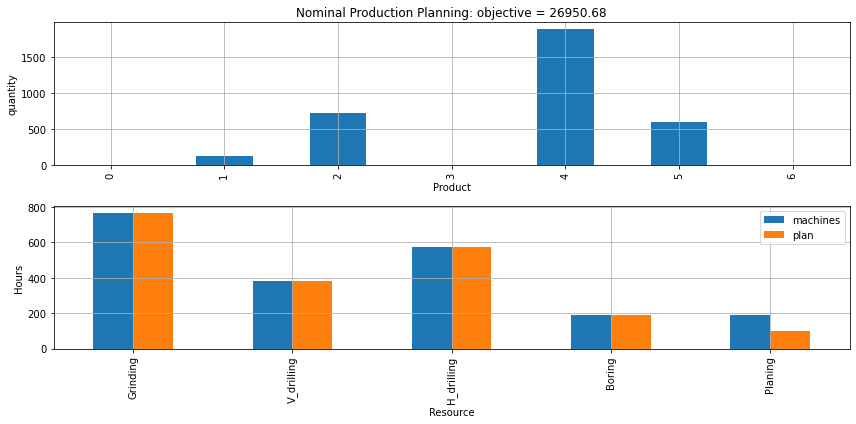

In [99]:
def display_plan(m, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(12, 6))
        
    print(m.objective())

    x = pd.Series({p: m.x[p]() for p in m.P}, name=m.name)
    x.plot(ax=ax[0], kind="bar", xlabel="Product", ylabel="quantity",
           title=m.name  + f": objective = {m.objective():0.2f}", grid=True)

    resources = pd.concat([hours*nb_machines, production.T @ x], axis=1)
    resources.columns = ["machines", "plan"]
    resources.plot(ax=ax[1], kind="bar", xlabel="Resource", ylabel="Hours", grid=True)
    
    fig.tight_layout()
    
    return ax

display_plan(m);

## Robust Optimization

The robust optimization problem is given by

$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{p\in P} \tilde{a}_{p, r} x_p \leq b_r & \forall r\in R \\
& \; x_p \geq 0 & \forall p\in P
\end{align*}
$$

where $\tilde{a}_{p, r}$ denotes an uncertain coefficient. The uncertainty is modeled as 

$$\tilde{a}_{p, r} = a_{p, r} + z_{p, r} a'_{p, r}$$

where $a'_{p, r}$ is the maximum perturbation in coefficient $a_{p, r}$, and 

$$
\begin{align*}
| z_{p, r} | & \leq 1 & \forall p\in P, r \in R\\
\sum_{p\in P} |z_{p, r}| & \leq d & \forall r\in R
\end{align*}
$$

where $d$ is the 'uncertainty budget'. Together, these constraints form the uncertainty set $\cal{Z}$. The first constraint is a 'box' (or 'unit box', or 'interval') constraint that limits the range of each $\tilde{a}_{r, p} \in [a_{r,p} - a'_{r,p}, a_{r,p} + a'_{r,p}]$. For each $r\in R$, the floor (or integer part) of $d$ determines the number of elements of $\tilde{a}_{r, p}$ for $\p in P$ that can simultaneously reach the limits of the interval.

In [102]:
def rc(a, a_perturbation, b, c, d=1, title=None):
    """Returns robust counterpart."""
    
    unc_budget = 1
    
    m = pyo.ConcreteModel(title)

    m.P = pyo.Set(initialize=c.index)
    m.R = pyo.Set(initialize=b.index)

    # Variables = how much of each product we make
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    
    # sensitivity
    m.lam = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.s = pyo.Var(m.R, m.P, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return pyo.quicksum(m.x[p] * c.loc[p] for p in m.P)
    
    @m.Expression(m.R)
    def robustness_margin(m, r):
        return pyo.quicksum(m.s[r, p] for p in m.P) + unc_budget * m.lam[r]

    @m.Constraint(m.R)
    def resource(m, r):
        return b[r] >= pyo.quicksum(m.x[p] * a.loc[p, r] for p in m.P) + m.robustness_margin[r]
    
    @m.Constraint(m.R, m.P)
    def sensitivity(m, r, p):
        return m.s[r, p] >= a_perturbation.loc[p, r] * m.x[p] - m.lam[r]
    
    pyo.SolverFactory("cbc").solve(m)
    
    return m

m = rc(a = production, 
       a_perturbation = 0.05*production,
       b = nb_machines*hours,
       c = profit, 
       d = 1,
       title = "Robust Production Planning")

m.robustness_margin.display()

robustness_margin : Size=5
    Key        : Value
        Boring : 8.959628259999999
      Grinding :        26.8788847
    H_drilling :         27.428571
       Planing :       95.54657514
    V_drilling :        17.0641884


## Is the Nominal Solution Robust to Uncertain Parameters?

Suppose the actual number of hours required to process each product on each machine is subject to some degree of uncertainty. For example, suppose r

In [32]:
np.random.uniform(size=production.shape)

array([[0.85366655, 0.38817038, 0.52333519, 0.24875468, 0.27408678],
       [0.2985187 , 0.04126641, 0.07766843, 0.89292629, 0.20317096],
       [0.20042193, 0.82892677, 0.20104202, 0.51095057, 0.27849991],
       [0.53999333, 0.14609457, 0.08291732, 0.08253205, 0.53156308],
       [0.85576218, 0.81333425, 0.99928072, 0.0944774 , 0.3323154 ],
       [0.71618646, 0.91633735, 0.05859758, 0.14011735, 0.41663535],
       [0.48037503, 0.51866547, 0.2137381 , 0.80993264, 0.54758338]])

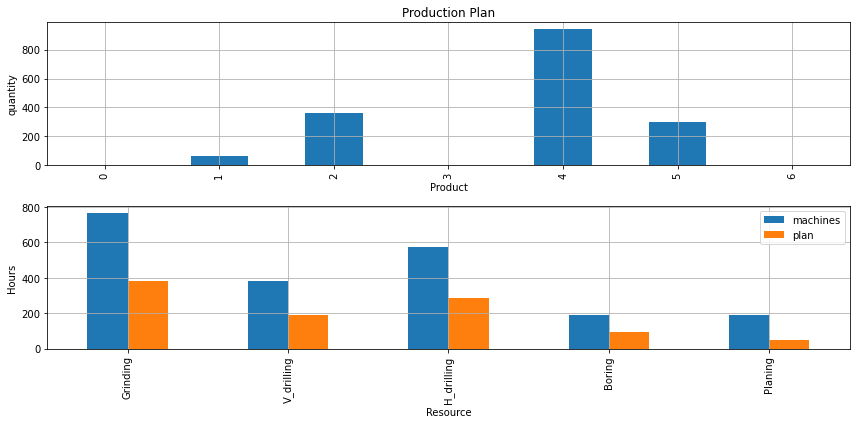

In [27]:
dmax = 1.0
m = production_model(nb_machines, 
                     (1 + dmax)*production, 
                     profit, 
                     hours)
display_plan(m);

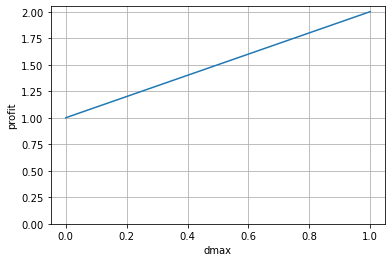

In [26]:
fig, ax = plt.subplots(1, 1)

def np_map(func, array):
    return np.array(list(map(func, array)))

dmax = np.linspace(0, 1.0, 21)
total_profit = np_map(lambda d: production_model(nb_machines, production/(1+d), profit, hours).total_profit(), dmax)

ax.plot(dmax, total_profit/total_profit[0])
ax.set_ylim(0,)
ax.set_xlabel('dmax')
ax.set_ylabel('profit')
ax.grid(True)

## Robust Optimization

$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{r\in R} (1 + z_{p, r})h_{p, r} x_p \leq n_r H & \forall p\in P, \forall |z_{p, r}| \leq \Delta
\end{align*}
$$


$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{r\in R} h_{p, r} x_p + \sum_{r\in R} z_{p, r}h_{p, r} x_p \leq n_r H & \forall p\in P, \forall |z_{p, r}| \leq \Delta
\end{align*}
$$

where $z_{p,r}$ are parameters expressing the relative uncertainty in the time required to perform operation with resource $r$

$$|z_{p, r}| \leq \Delta$$

where $\Delta$ establishes an upper bound on the relative uncertainty. 

$$s_{p, r} = z_{p, r} h_{p, r}$$

In [13]:
# We shall now solve the robust problem with each (product, machine) time deviating
# by at most max_perturbation * 100%,
# and per machine the  at most unc_budget products in total deviate by their max

max_perturbation = 0.05
unc_budget = 1

production_perturbation = production.applymap(lambda x: x * max_perturbation)
display("production perturbation", production_perturbation)

m = pyo.ConcreteModel("Production planning")

m.products = pyo.Set(initialize=profit.index)
m.resources = pyo.Set(initialize=production.columns)

# Old variables
m.p = pyo.Var(m.products, domain=pyo.NonNegativeReals)

# Variable which will act as a proxy on s >= abs(duration - nominal duration)
m.s = pyo.Var(m.products, m.resources, domain=pyo.NonNegativeReals)

# Dual variable related to the budget constraint in the uncertainty set
m.lam = pyo.Var(m.resources, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def total_profit(m):
    return pyo.quicksum(m.p[product] * profit.loc[product] for product in m.products)

@m.Constraint(m.resources)
def machine_availability(m, resource):
    return pyo.quicksum(m.p[product] * production.loc[product, resource] for product in m.products) \
            + pyo.quicksum(m.s[product, resource] for product in m.products) + unc_budget * m.lam[resource] \
            <= hours * nb_machines[resource]

@m.Constraint(m.products, m.resources)
def constraint2(m, product, resource):
    return m.s[product, resource] >= m.p[product] * production_perturbation.loc[product, resource] - m.lam[resource]

solver = pyo.SolverFactory("cbc")
solver.solve(m)

# Extract the solution
robust_plan = pd.Series({i: m.p[i]() for i in m.products}, name="Robust")
production_plans = pd.concat([nominal_plan, robust_plan], axis=1)
production_plans.index.name = "Product"
display(production_plans)

'production perturbation'

,Grinding,V_drilling,H_drilling,Boring,Planing
Product,,,,,
0,0.025,0.005,0.01,0.0025,0.0000
1,0.035,0.010,0.00,0.0015,0.0000
2,0.000,0.000,0.04,0.0000,0.0005
3,0.000,0.015,0.00,0.0035,0.0000
4,0.015,0.000,0.00,0.0050,0.0025
5,0.010,0.030,0.00,0.0000,0.0000
6,0.025,0.000,0.03,0.0040,0.0025


,Nominal,Robust
Product,,
0,0.00000,0.00000
1,117.79141,128.26024
2,720.00000,685.71429
3,0.00000,0.00000
4,1884.66260,1791.92560
5,600.73620,568.80627
6,0.00000,0.00000


<AxesSubplot:title={'center':'Production Plans'}, xlabel='product', ylabel='quantity'>

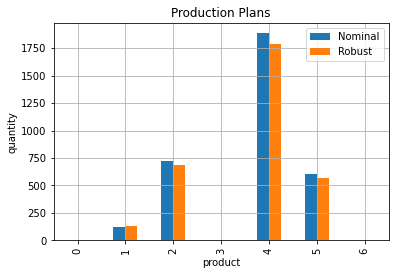

In [21]:
production_plans.plot(kind="bar", xlabel="product", ylabel="quantity", title="Production Plans", grid=True)

In [22]:
# compute profits for each plan by taking dot product
display(production_plans.T @ profit)

Nominal    26950.67506
Robust     25709.93699
dtype: float64